In [1]:
%load_ext autoreload
%autoreload 2
    
from context import uncertify

In [2]:
import logging
from uncertify.log import setup_logging
setup_logging()
LOG = logging.getLogger(__name__)

# Matplotlib DEBUG logging spits out a whole bunch of crap
mpl_logger = logging.getLogger('matplotlib')
mpl_logger.setLevel(logging.WARNING)

In [3]:
from itertools import islice
from pathlib import Path

import h5py
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

from uncertify.common import DATA_DIR_PATH

from typing import List

In [4]:
BRATS_DATA_DIR = Path('/scratch/maheer/datasets/processed/')  # DATA_DIR_PATH / 'brats'
CAMCAN_DATA_DIR = DATA_DIR_PATH / 'camcan'

# Explore dataset
Constist of two major types of objects: Datasets and Groups.

Datasets: multidimensional arrays of homogeneous types.
Groups: Hierarchical structures (file system-like).

In [5]:
brats_val_path = BRATS_DATA_DIR / 'brats_test_std.hdf5'
#brats_t1_path = BRATS_DATA_DIR / 'brats_t1_no_hm_unbiased.hdf5'
#camcan_val_path = CAMCAN_DATA_DIR / 'camcan_t2_val_set.hdf5'
#camcan_train_path = CAMCAN_DATA_DIR / 'camcan_t2_train_set.hdf5'

def print_dataset_information(dataset_paths: List[Path]) -> None:
    for path in dataset_paths:
        print(f'{path} does{" not " if not path.exists() else " "}exist!')
    
    def print_datasets_info(h5py_file: h5py.File) -> None:
        for dataset_name, dataset in h5py_file.items():
            print(dataset)

    for path in dataset_paths:
        name = path.name
        h5py_file = h5py.File(path, 'r')
        print(f'\n --- {name} ---')
        print_datasets_info(h5py_file)
    return h5py_file

h5py_file = print_dataset_information(dataset_paths=[brats_val_path]) # , camcan_val_path, camcan_train_path, brats_t1_path])

/scratch/maheer/datasets/processed/brats_test_std.hdf5 does exist!

 --- brats_test_std.hdf5 ---
<HDF5 dataset "Mask": shape (155, 40000), type "<f8">
<HDF5 dataset "Scan": shape (155, 40000), type "<f8">
<HDF5 dataset "Seg": shape (155, 40000), type "<f8">


Mask           : min/max: 0.00/1.00, mean: 0.44, variance: 0.25
Scan           : min/max: -5.45/1.88, mean: -1.84, variance: 3.89
Seg            : min/max: 0.00/1.00, mean: 0.00, variance: 0.00
Masked_Scan    : min/max: -5.45/1.88, mean: 0.31, variance: 0.74
2020-10-12 20:06:37,243 : matplotlib.font_manager : WARNING    findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


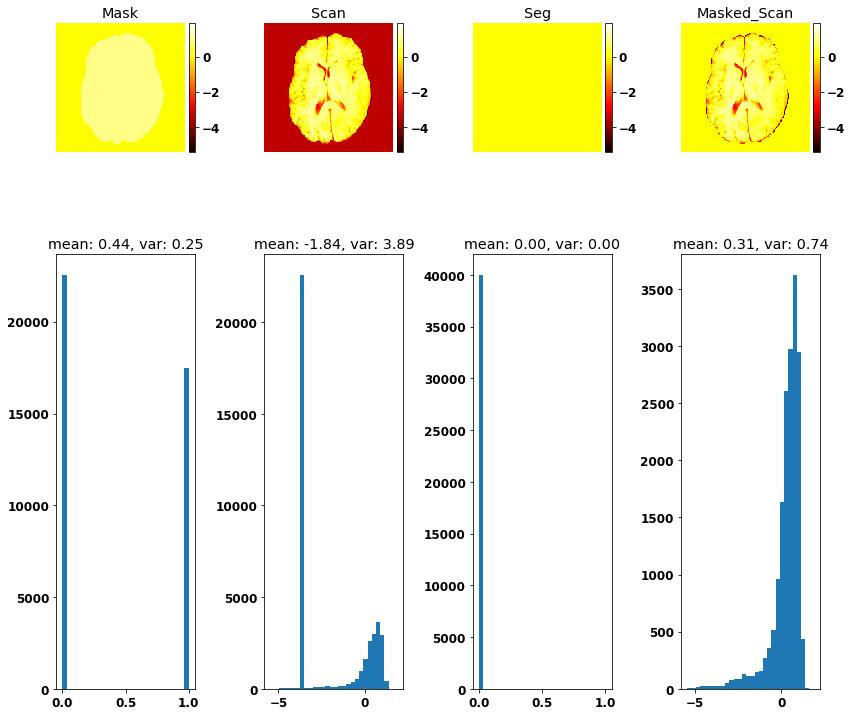

Mask           : min/max: 0.00/1.00, mean: 0.44, variance: 0.25
Scan           : min/max: -5.44/1.75, mean: -1.84, variance: 3.88
Seg            : min/max: 0.00/0.00, mean: 0.00, variance: 0.00
Masked_Scan    : min/max: -5.44/1.75, mean: 0.29, variance: 0.77


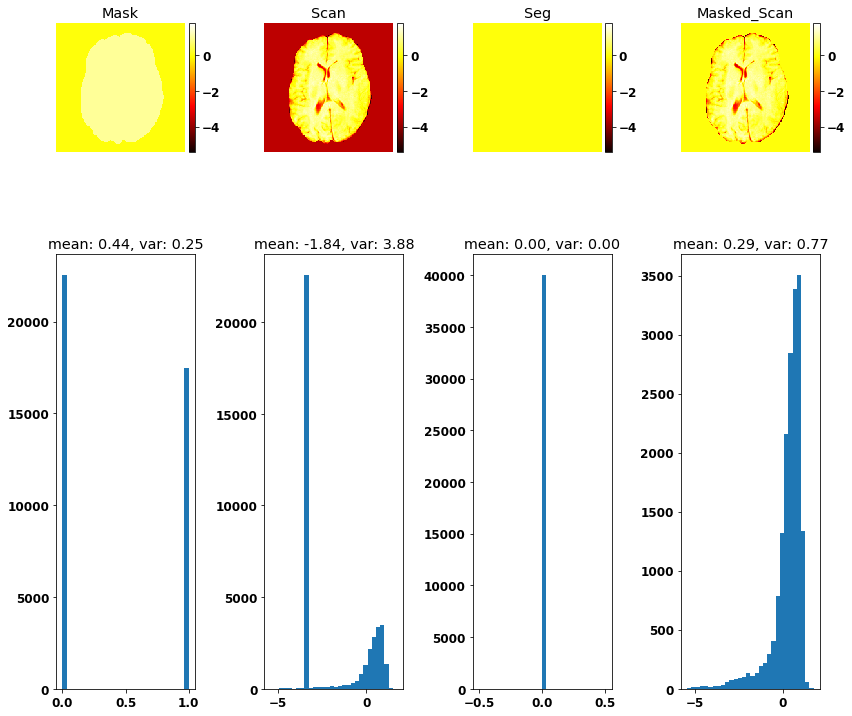

Mask           : min/max: 0.00/1.00, mean: 0.41, variance: 0.24
Scan           : min/max: -5.25/1.42, mean: -1.97, variance: 3.65
Seg            : min/max: 0.00/0.00, mean: 0.00, variance: 0.00
Masked_Scan    : min/max: -5.25/1.42, mean: 0.26, variance: 0.59


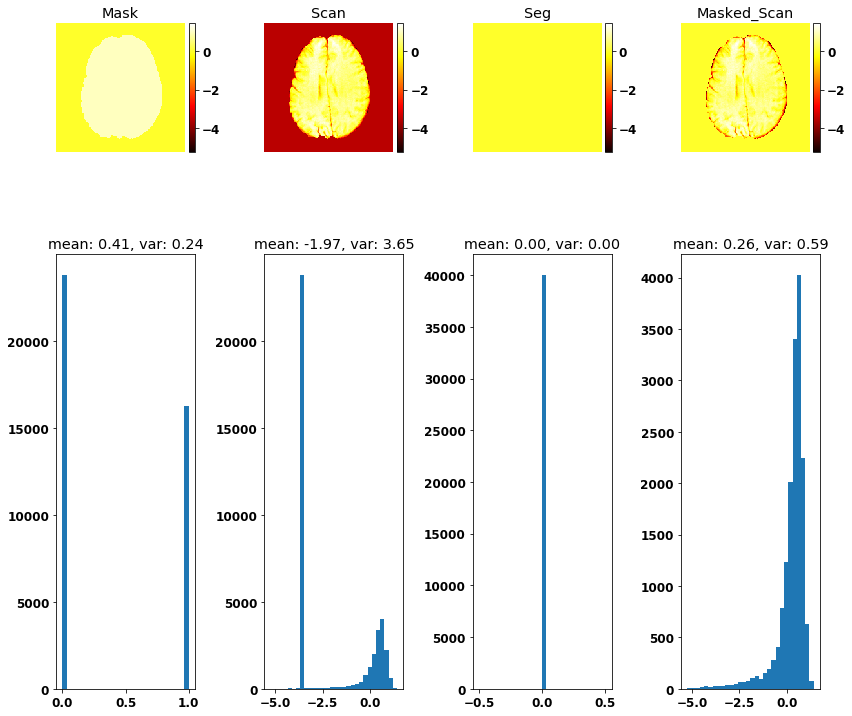

Mask           : min/max: 0.00/1.00, mean: 0.19, variance: 0.15
Scan           : min/max: -5.52/1.16, mean: -2.94, variance: 1.56
Seg            : min/max: 0.00/1.00, mean: 0.01, variance: 0.01
Masked_Scan    : min/max: -5.52/1.16, mean: -0.52, variance: 1.05


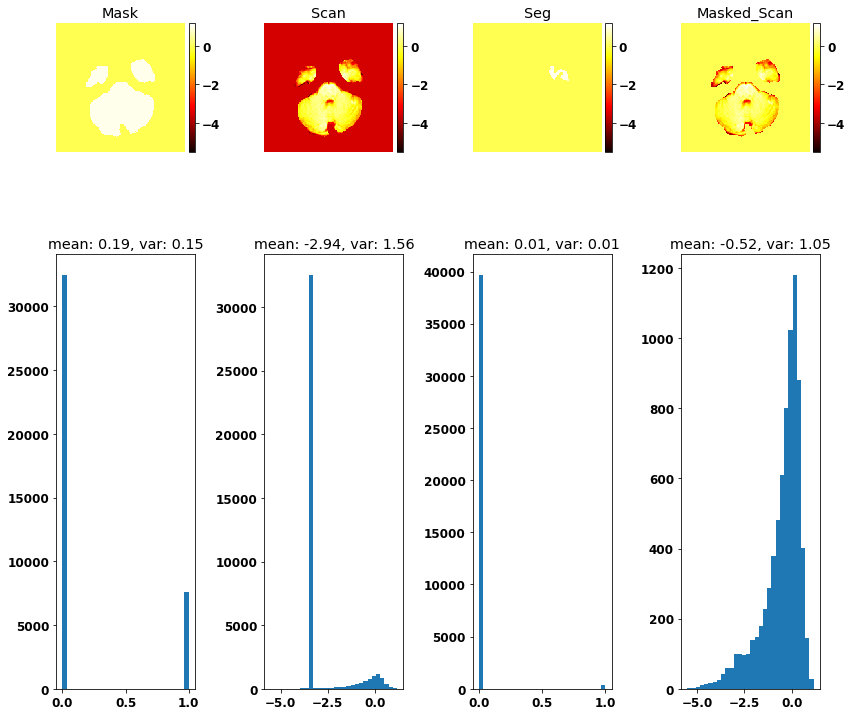

Mask           : min/max: 0.00/0.00, mean: 0.00, variance: 0.00
Scan           : min/max: -3.50/-3.50, mean: -3.50, variance: 0.00
Seg            : min/max: 0.00/0.00, mean: 0.00, variance: 0.00
Found sample with empty mask. No statistics available.


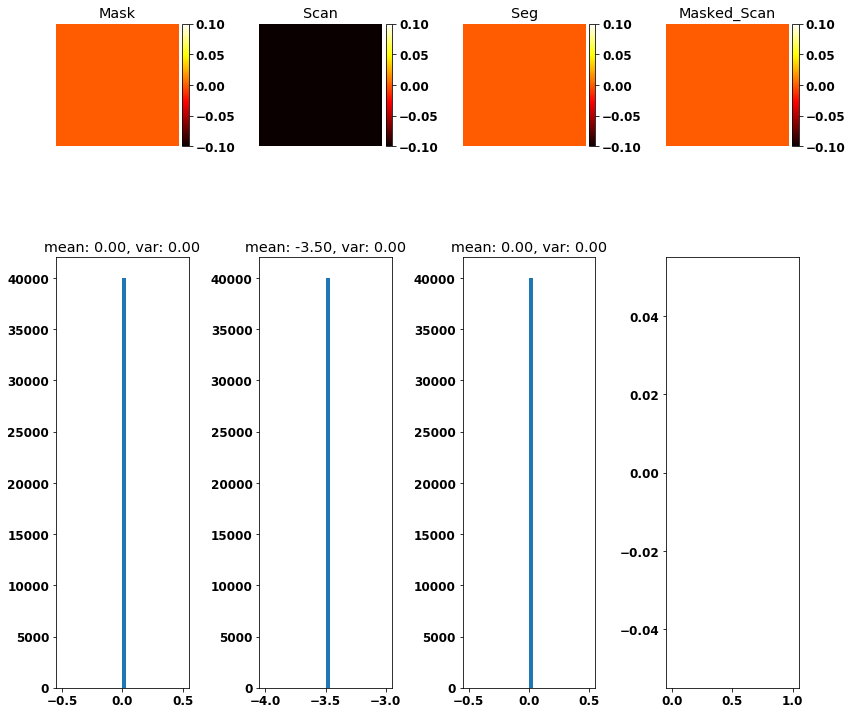

Mask           : min/max: 0.00/1.00, mean: 0.39, variance: 0.24
Scan           : min/max: -5.52/1.50, mean: -2.04, variance: 3.54
Seg            : min/max: 0.00/0.00, mean: 0.00, variance: 0.00
Masked_Scan    : min/max: -5.52/1.50, mean: 0.22, variance: 0.62


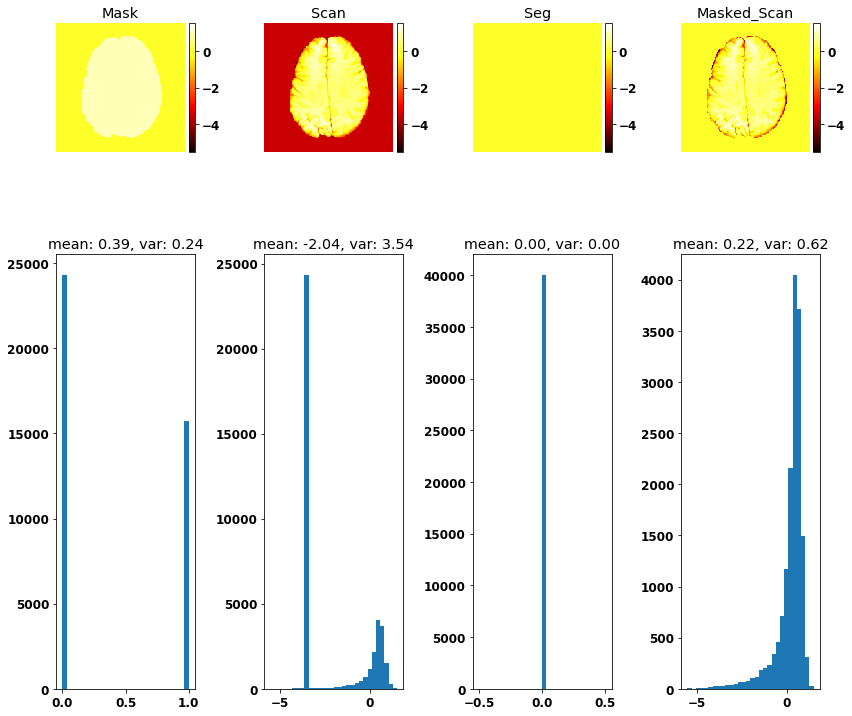

Mask           : min/max: 0.00/1.00, mean: 0.14, variance: 0.12
Scan           : min/max: -3.95/3.22, mean: -3.01, variance: 1.72
Seg            : min/max: 0.00/0.00, mean: 0.00, variance: 0.00
Masked_Scan    : min/max: -3.95/3.22, mean: 0.07, variance: 1.47


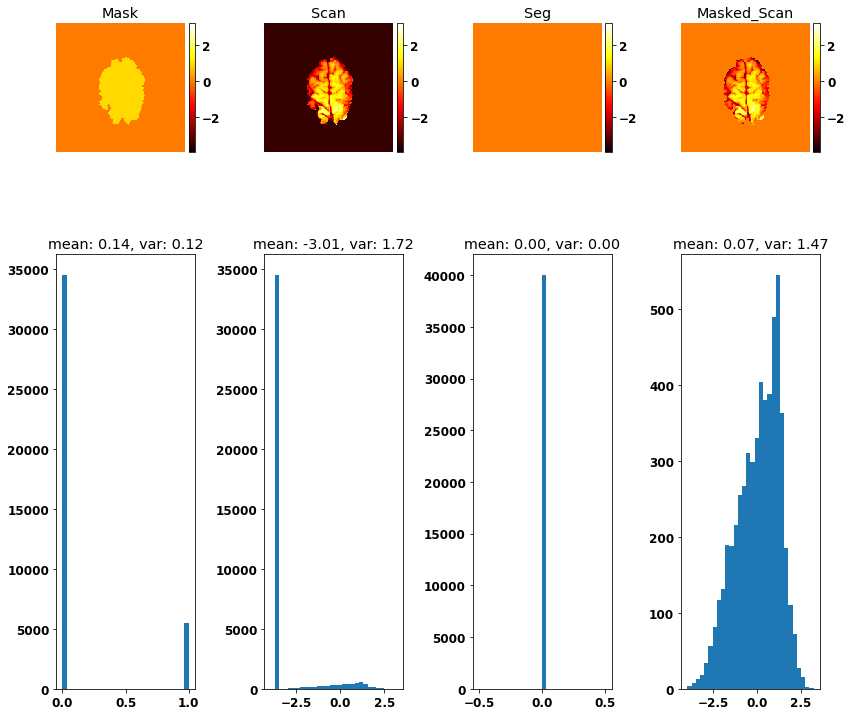

Mask           : min/max: 0.00/1.00, mean: 0.42, variance: 0.24
Scan           : min/max: -5.54/1.54, mean: -1.93, variance: 3.70
Seg            : min/max: 0.00/0.00, mean: 0.00, variance: 0.00
Masked_Scan    : min/max: -5.54/1.54, mean: 0.27, variance: 0.59


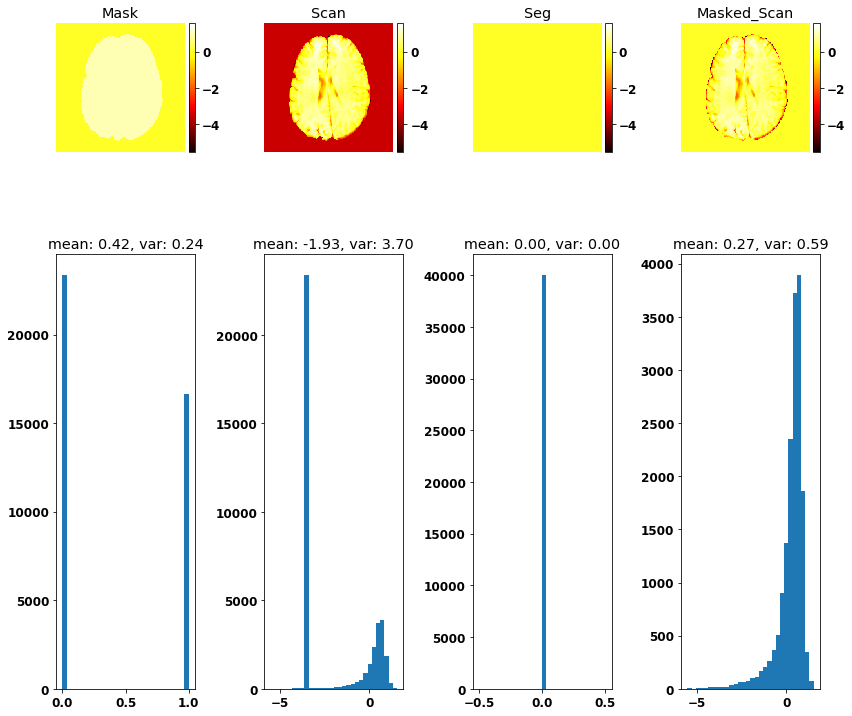

Mask           : min/max: 0.00/1.00, mean: 0.01, variance: 0.01
Scan           : min/max: -3.50/2.63, mean: -3.46, variance: 0.16
Seg            : min/max: 0.00/0.00, mean: 0.00, variance: 0.00
Masked_Scan    : min/max: -2.46/2.63, mean: 0.21, variance: 0.92


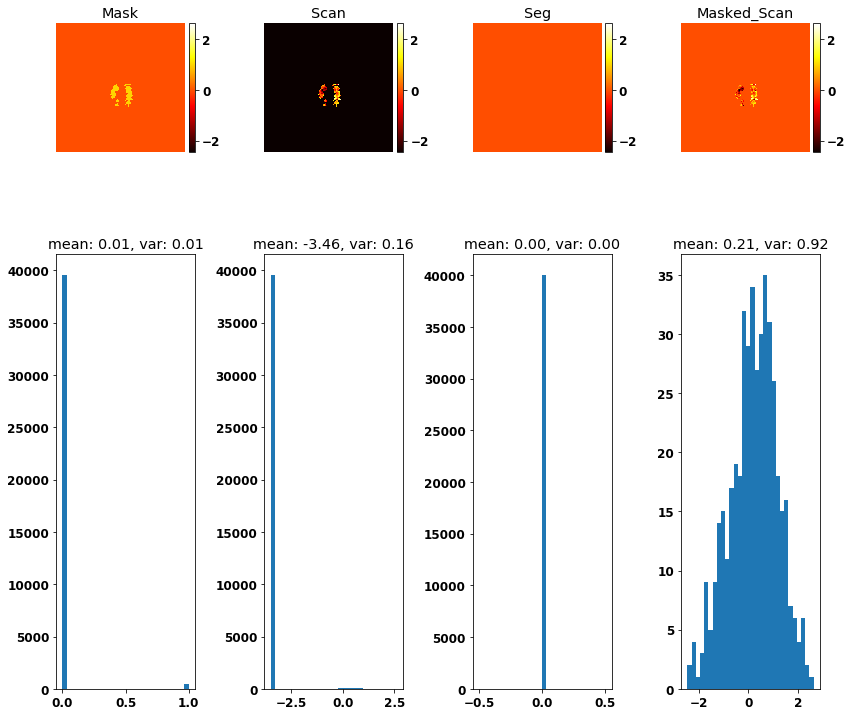

Mask           : min/max: 0.00/1.00, mean: 0.12, variance: 0.11
Scan           : min/max: -5.14/0.97, mean: -3.14, variance: 1.04
Seg            : min/max: 0.00/0.00, mean: 0.00, variance: 0.00
Masked_Scan    : min/max: -5.14/0.97, mean: -0.55, variance: 0.92


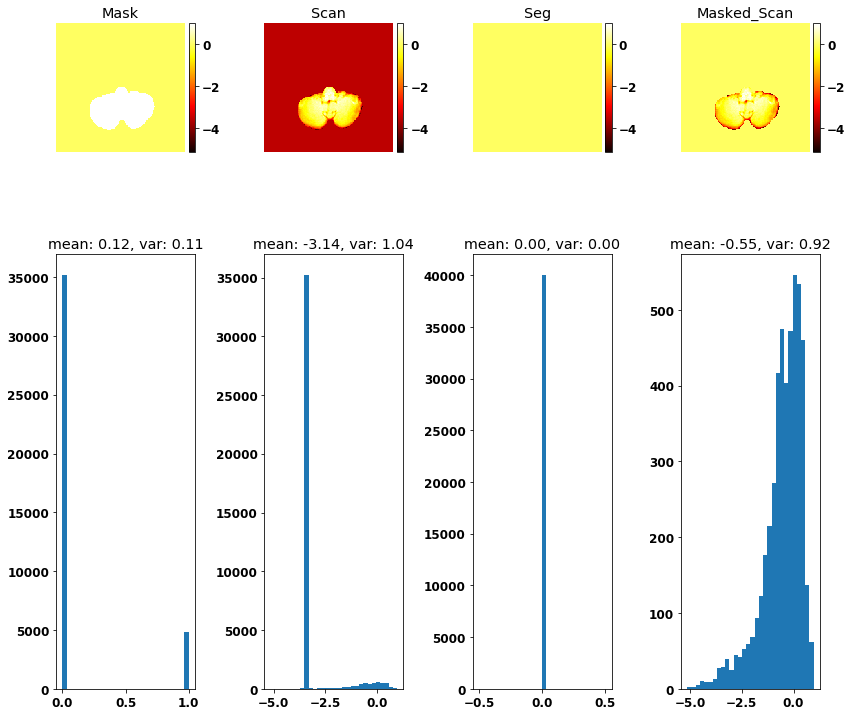

Mask           : min/max: 0.00/1.00, mean: 0.29, variance: 0.20
Scan           : min/max: -4.59/1.60, mean: -2.49, variance: 2.77
Seg            : min/max: 0.00/0.00, mean: 0.00, variance: 0.00
Masked_Scan    : min/max: -4.59/1.60, mean: 0.04, variance: 0.73


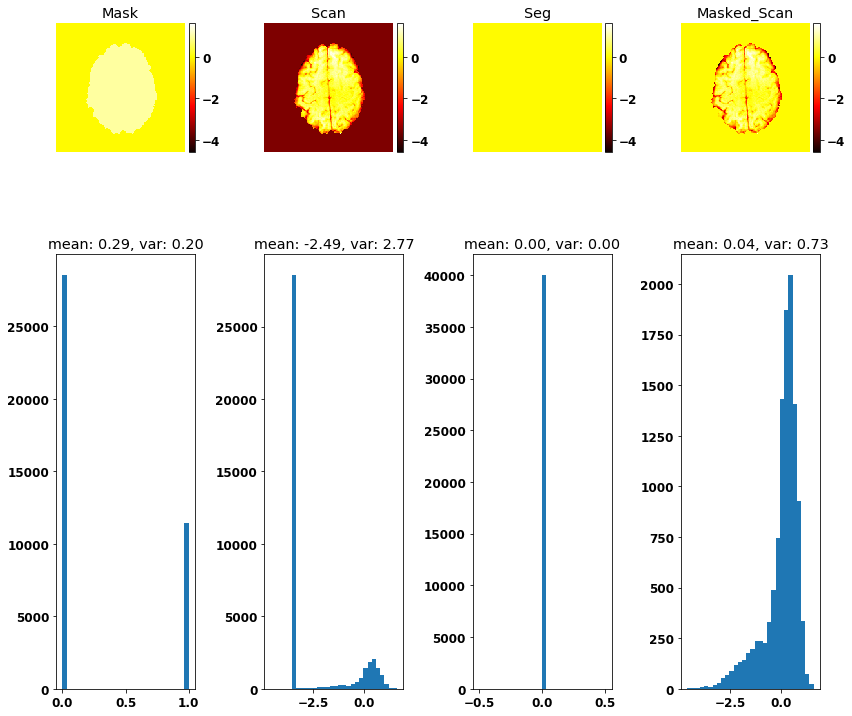

Mask           : min/max: 0.00/0.00, mean: 0.00, variance: 0.00
Scan           : min/max: -3.50/-3.50, mean: -3.50, variance: 0.00
Seg            : min/max: 0.00/0.00, mean: 0.00, variance: 0.00
Found sample with empty mask. No statistics available.


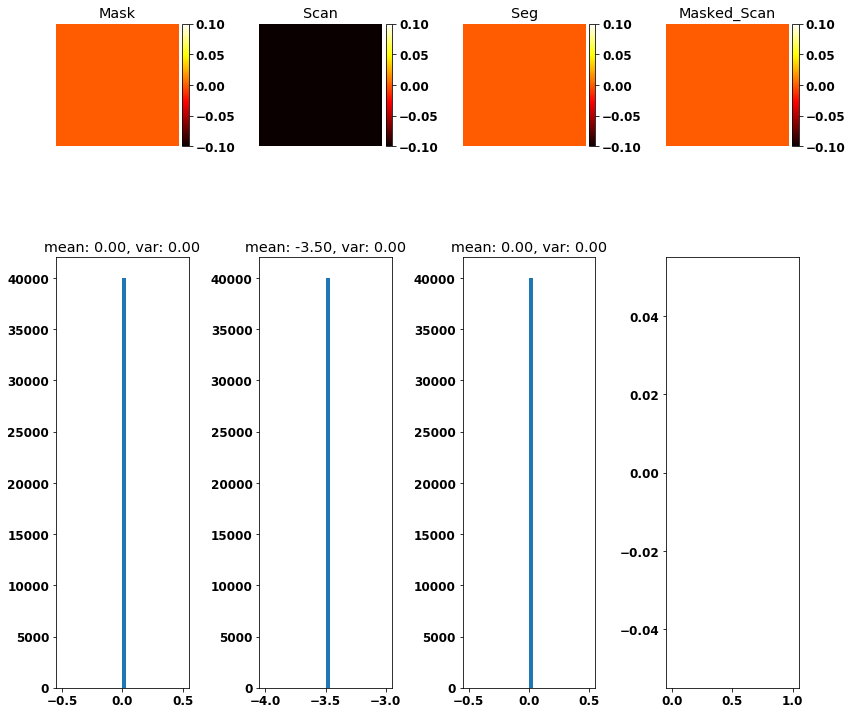

Mask           : min/max: 0.00/1.00, mean: 0.33, variance: 0.22
Scan           : min/max: -5.55/1.42, mean: -2.40, variance: 2.81
Seg            : min/max: 0.00/1.00, mean: 0.05, variance: 0.05
Masked_Scan    : min/max: -5.55/1.42, mean: -0.16, variance: 1.03


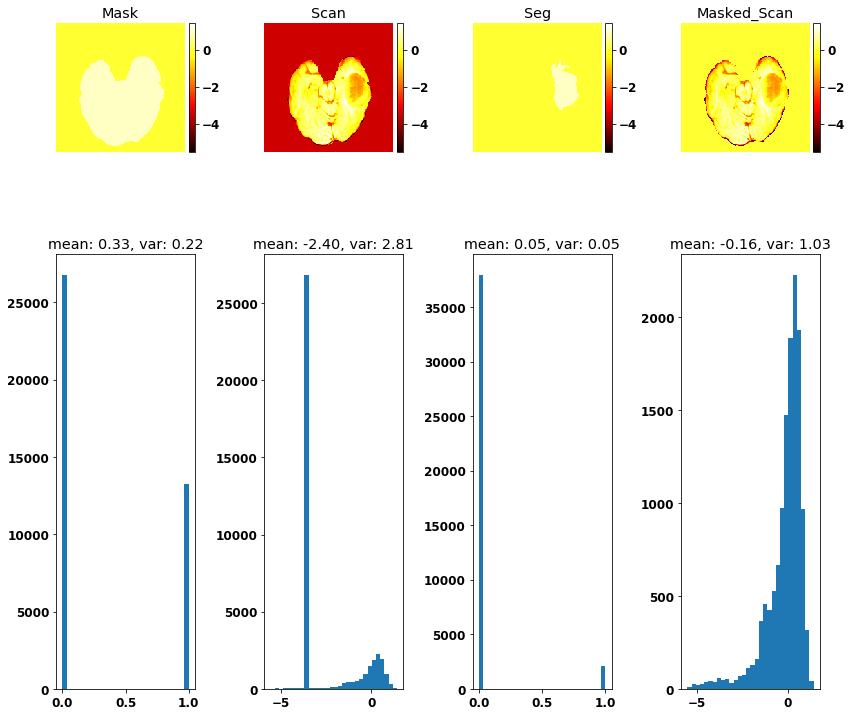

Mask           : min/max: 0.00/1.00, mean: 0.44, variance: 0.25
Scan           : min/max: -5.39/1.68, mean: -1.84, variance: 3.86
Seg            : min/max: 0.00/1.00, mean: 0.02, variance: 0.02
Masked_Scan    : min/max: -5.39/1.68, mean: 0.28, variance: 0.80


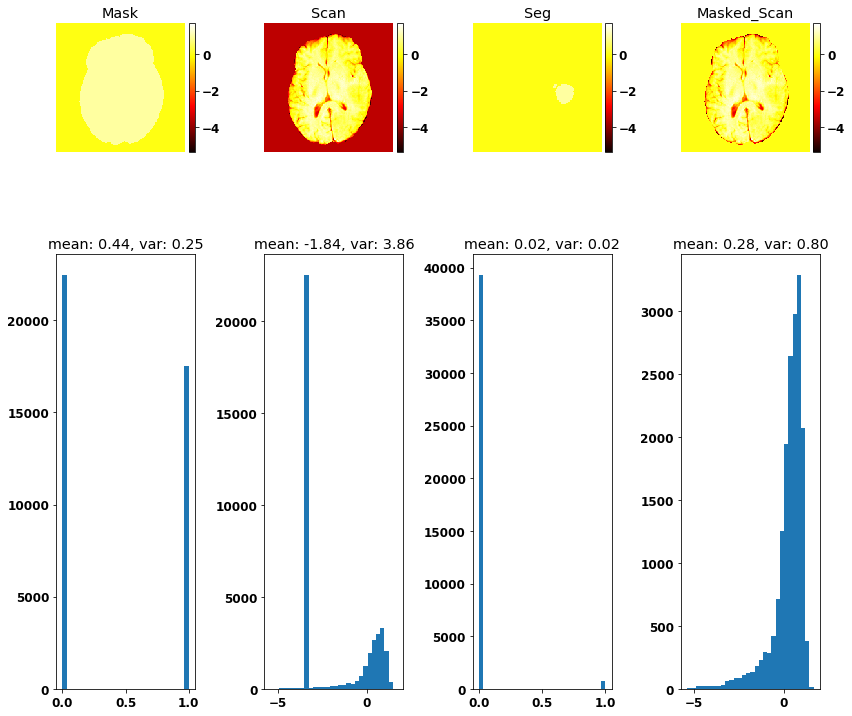

Mask           : min/max: 0.00/1.00, mean: 0.42, variance: 0.24
Scan           : min/max: -5.47/1.49, mean: -1.90, variance: 3.74
Seg            : min/max: 0.00/0.00, mean: 0.00, variance: 0.00
Masked_Scan    : min/max: -5.47/1.49, mean: 0.26, variance: 0.67


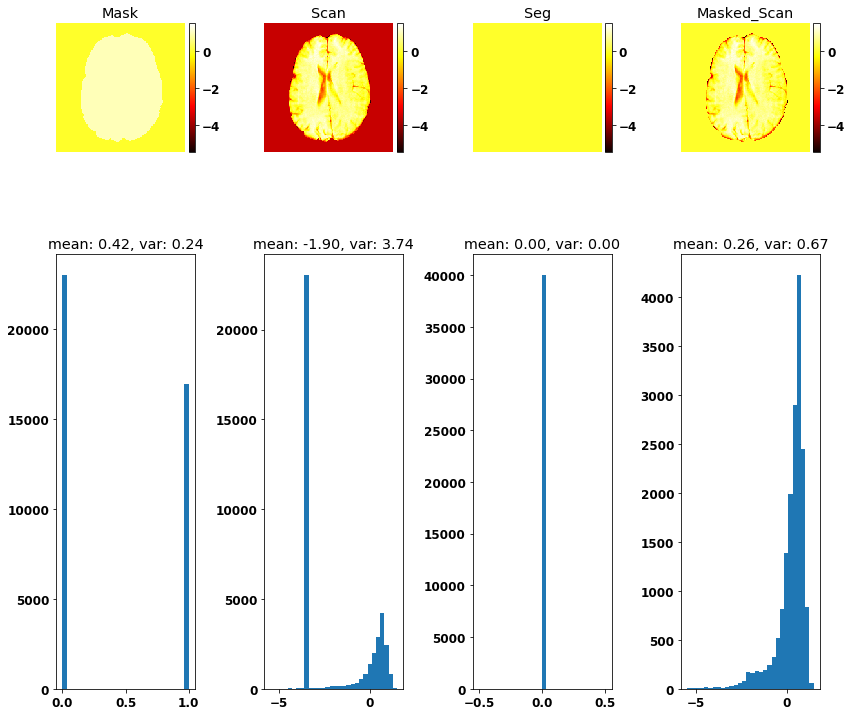

Mask           : min/max: 0.00/1.00, mean: 0.21, variance: 0.17
Scan           : min/max: -4.99/1.13, mean: -2.88, variance: 1.68
Seg            : min/max: 0.00/1.00, mean: 0.01, variance: 0.01
Masked_Scan    : min/max: -4.99/1.13, mean: -0.58, variance: 1.22


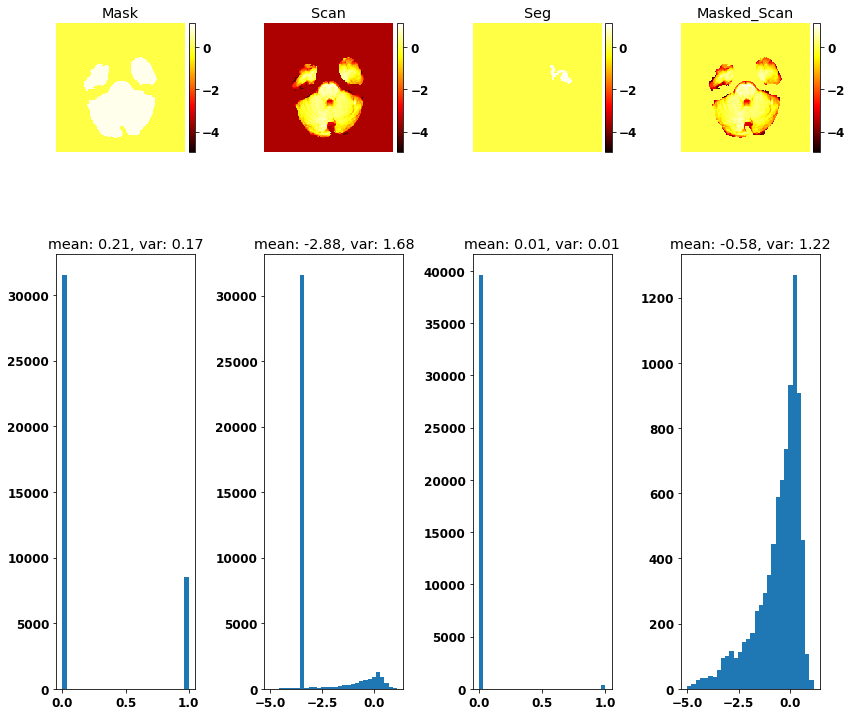

Mask           : min/max: 0.00/1.00, mean: 0.05, variance: 0.05
Scan           : min/max: -4.28/1.55, mean: -3.38, variance: 0.33
Seg            : min/max: 0.00/0.00, mean: 0.00, variance: 0.00
Masked_Scan    : min/max: -4.28/1.55, mean: -1.18, variance: 1.26


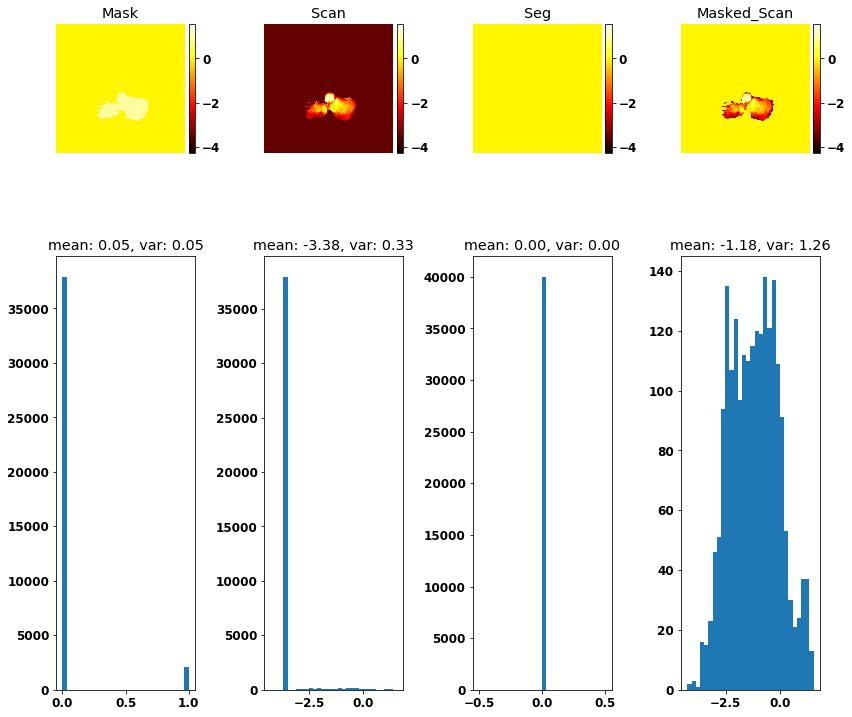

Mask           : min/max: 0.00/1.00, mean: 0.39, variance: 0.24
Scan           : min/max: -5.51/1.78, mean: -2.11, variance: 3.41
Seg            : min/max: 0.00/1.00, mean: 0.05, variance: 0.05
Masked_Scan    : min/max: -5.51/1.78, mean: 0.04, variance: 1.06


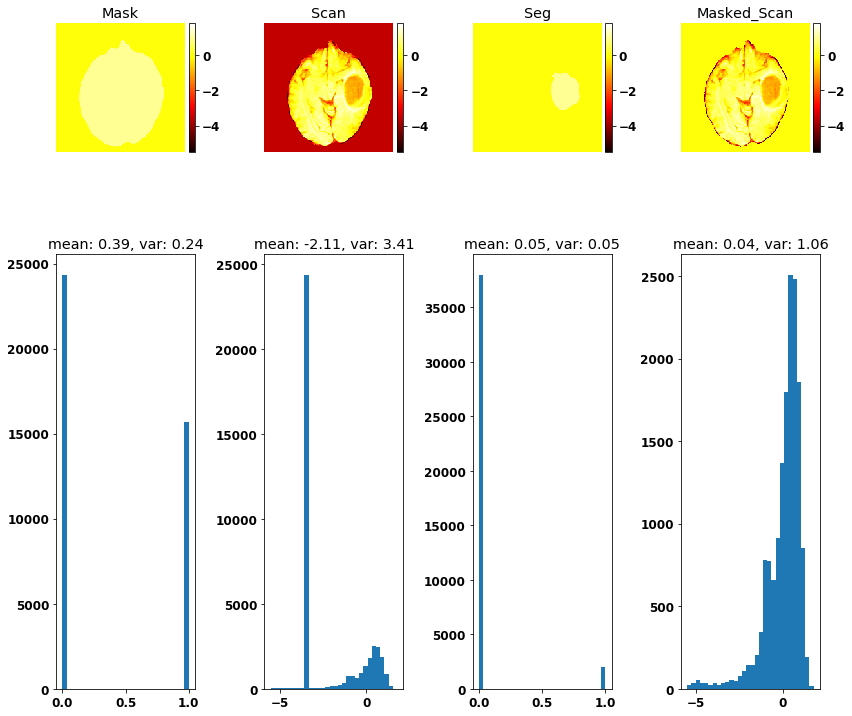

Mask           : min/max: 0.00/1.00, mean: 0.12, variance: 0.11
Scan           : min/max: -5.14/0.97, mean: -3.14, variance: 1.04
Seg            : min/max: 0.00/0.00, mean: 0.00, variance: 0.00
Masked_Scan    : min/max: -5.14/0.97, mean: -0.55, variance: 0.92


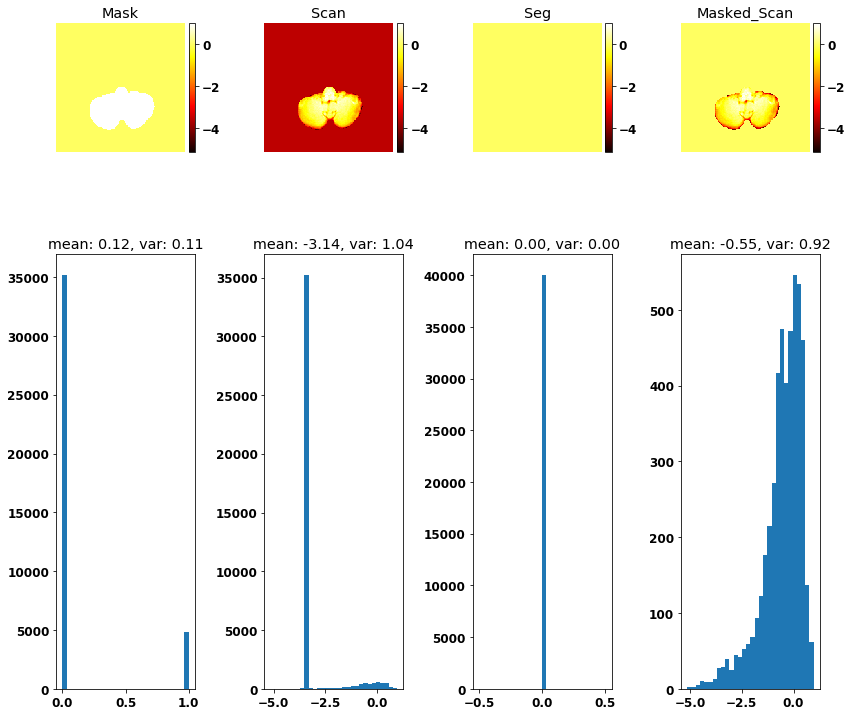

Mask           : min/max: 0.00/1.00, mean: 0.44, variance: 0.25
Scan           : min/max: -5.45/1.88, mean: -1.84, variance: 3.89
Seg            : min/max: 0.00/1.00, mean: 0.00, variance: 0.00
Masked_Scan    : min/max: -5.45/1.88, mean: 0.31, variance: 0.74


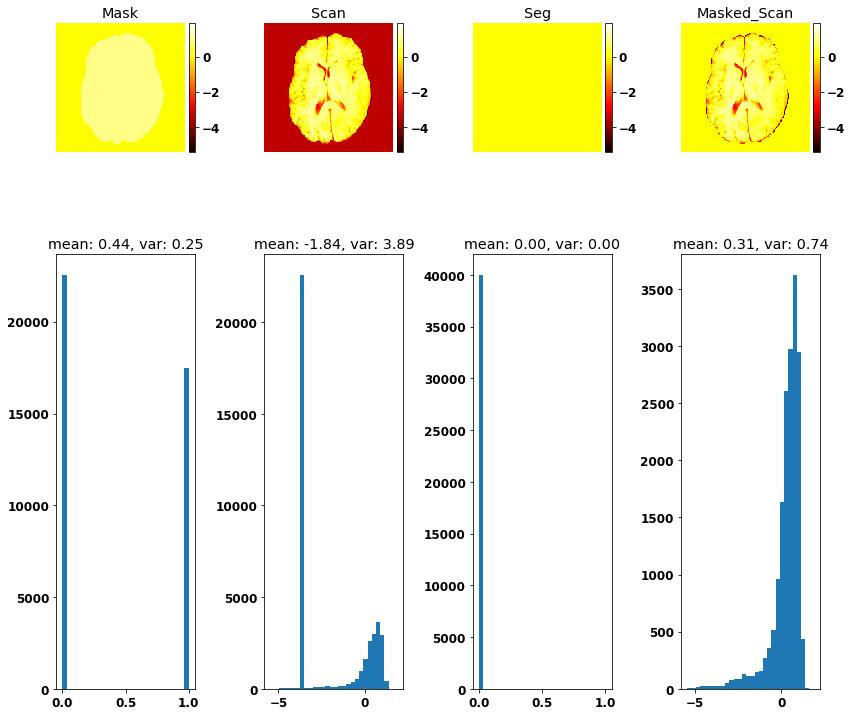

Mask           : min/max: 0.00/1.00, mean: 0.42, variance: 0.24
Scan           : min/max: -5.54/1.54, mean: -1.93, variance: 3.70
Seg            : min/max: 0.00/0.00, mean: 0.00, variance: 0.00
Masked_Scan    : min/max: -5.54/1.54, mean: 0.27, variance: 0.59


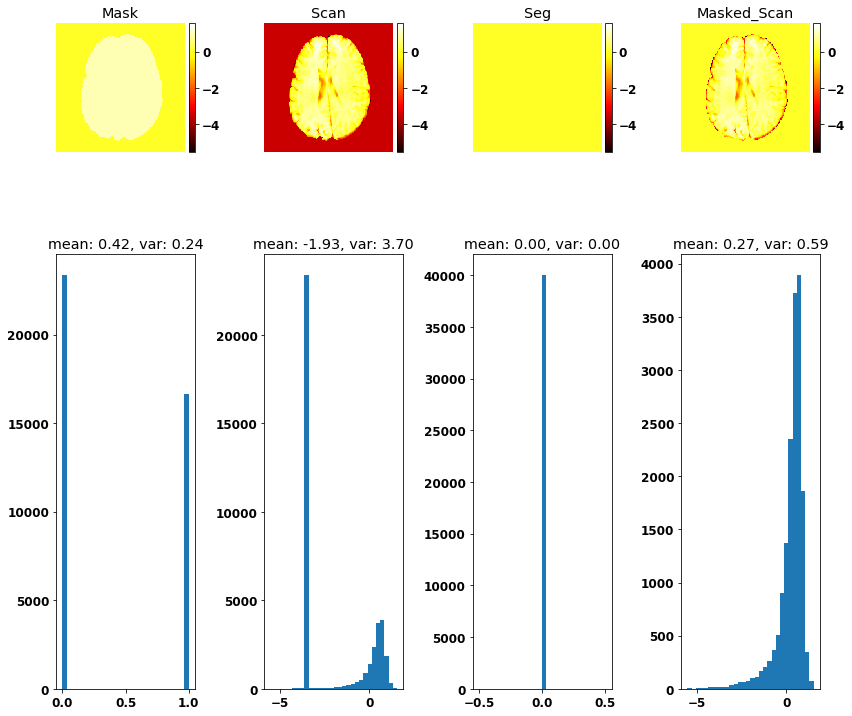

Mask           : min/max: 0.00/1.00, mean: 0.38, variance: 0.23
Scan           : min/max: -5.29/1.47, mean: -2.12, variance: 3.40
Seg            : min/max: 0.00/0.00, mean: 0.00, variance: 0.00
Masked_Scan    : min/max: -5.29/1.47, mean: 0.18, variance: 0.63


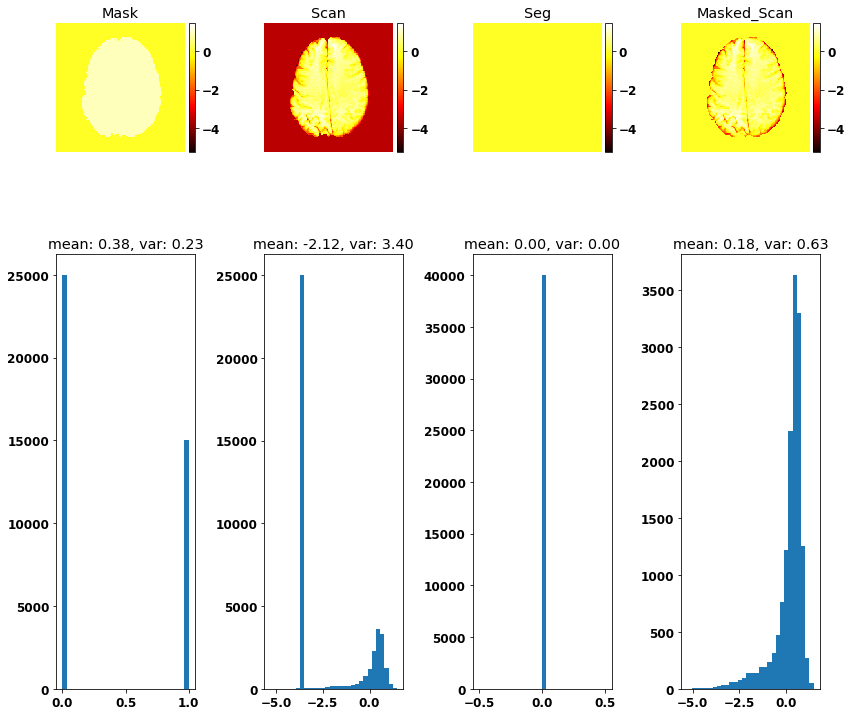

Mask           : min/max: 0.00/1.00, mean: 0.39, variance: 0.24
Scan           : min/max: -5.51/1.78, mean: -2.11, variance: 3.41
Seg            : min/max: 0.00/1.00, mean: 0.05, variance: 0.05
Masked_Scan    : min/max: -5.51/1.78, mean: 0.04, variance: 1.06


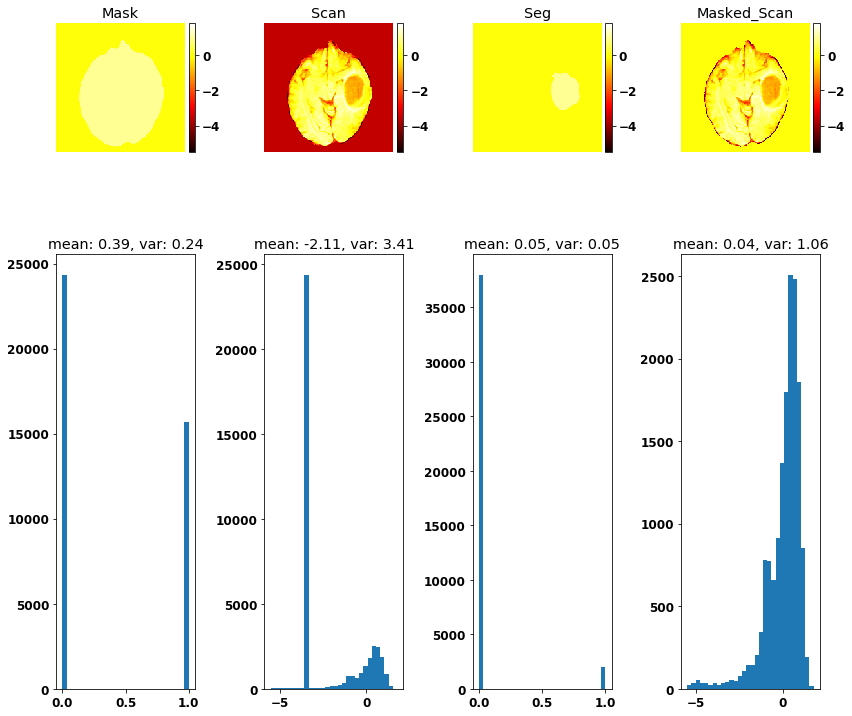

Mask           : min/max: 0.00/1.00, mean: 0.32, variance: 0.22
Scan           : min/max: -5.44/1.09, mean: -2.48, variance: 2.54
Seg            : min/max: 0.00/1.00, mean: 0.05, variance: 0.04
Masked_Scan    : min/max: -5.44/1.09, mean: -0.28, variance: 0.93


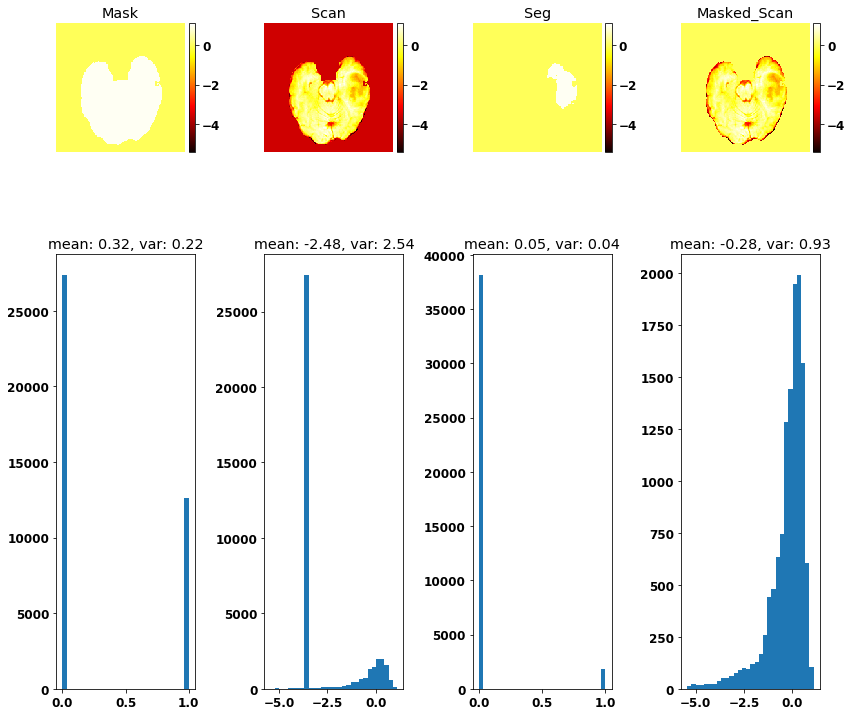

Mask           : min/max: 0.00/1.00, mean: 0.39, variance: 0.24
Scan           : min/max: -5.52/1.50, mean: -2.04, variance: 3.54
Seg            : min/max: 0.00/0.00, mean: 0.00, variance: 0.00
Masked_Scan    : min/max: -5.52/1.50, mean: 0.22, variance: 0.62


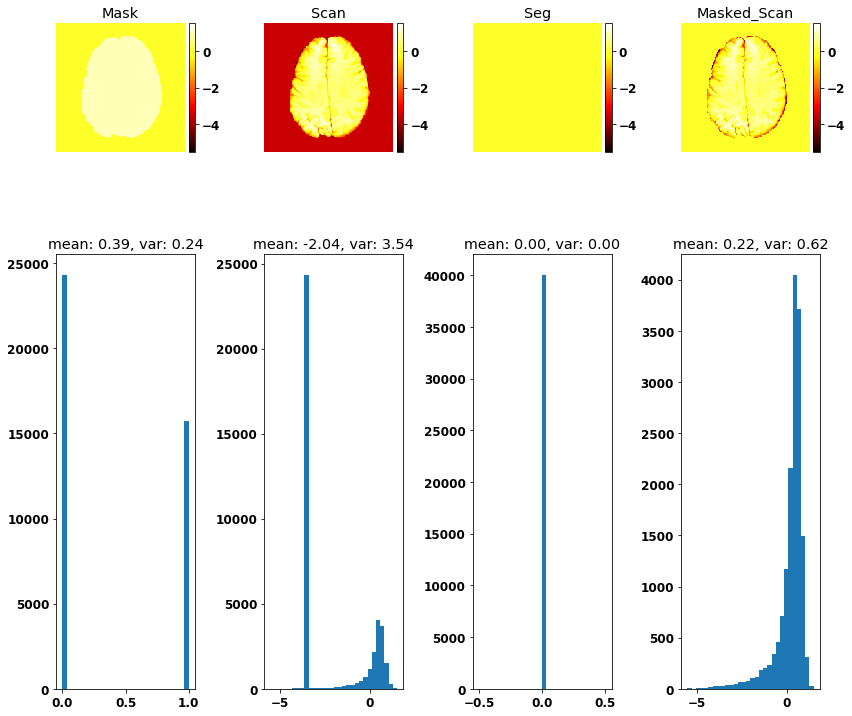

Mask           : min/max: 0.00/1.00, mean: 0.42, variance: 0.24
Scan           : min/max: -5.63/1.78, mean: -1.94, variance: 3.71
Seg            : min/max: 0.00/1.00, mean: 0.04, variance: 0.04
Masked_Scan    : min/max: -5.63/1.78, mean: 0.18, variance: 0.96


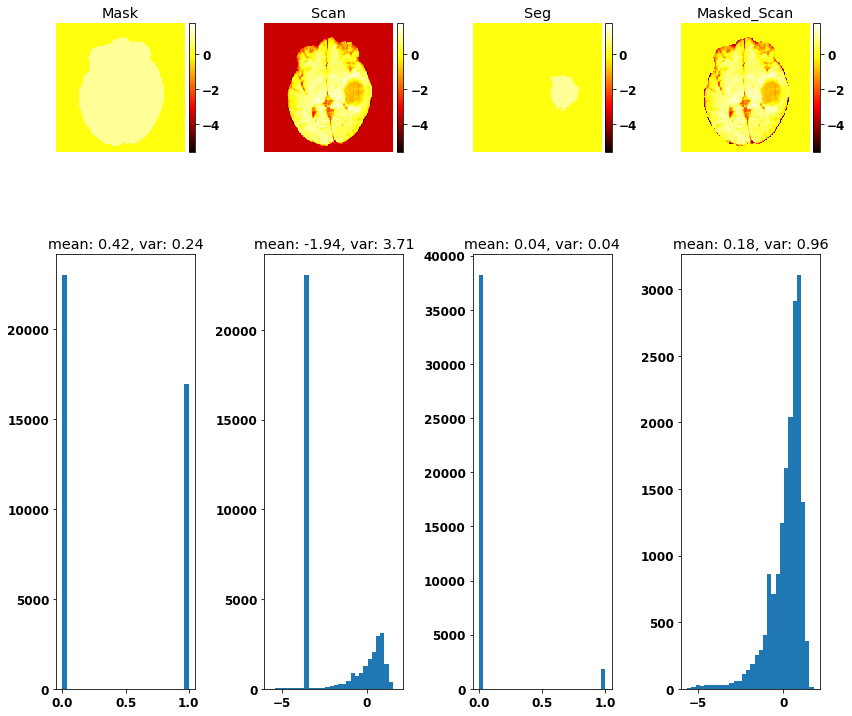

Mask           : min/max: 0.00/1.00, mean: 0.01, variance: 0.01
Scan           : min/max: -3.50/1.13, mean: -3.48, variance: 0.05
Seg            : min/max: 0.00/0.00, mean: 0.00, variance: 0.00
Masked_Scan    : min/max: -3.23/1.13, mean: -1.52, variance: 1.10


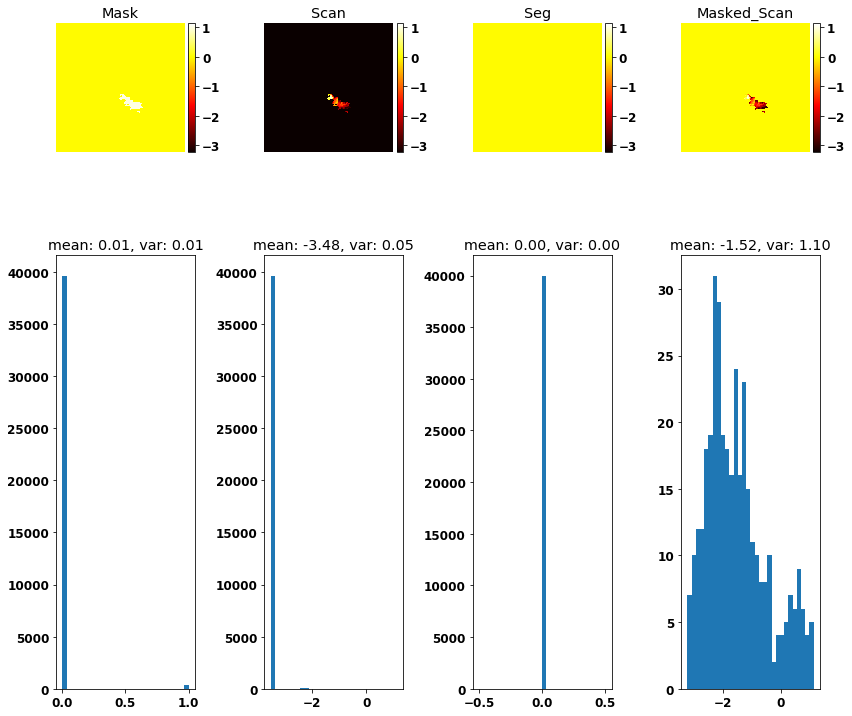

Mask           : min/max: 0.00/0.00, mean: 0.00, variance: 0.00
Scan           : min/max: -3.50/-3.50, mean: -3.50, variance: 0.00
Seg            : min/max: 0.00/0.00, mean: 0.00, variance: 0.00
Found sample with empty mask. No statistics available.


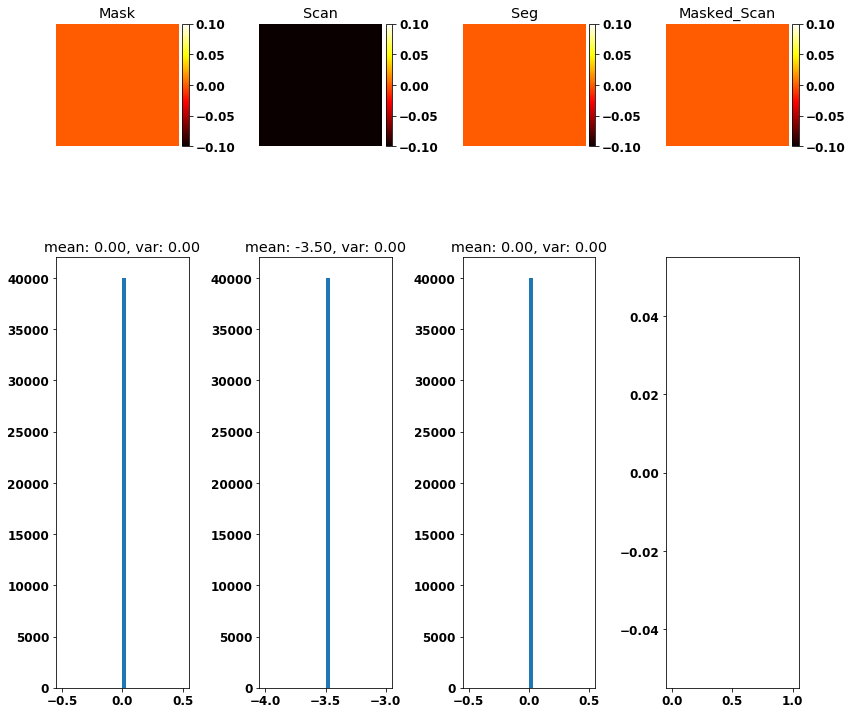

Mask           : min/max: 0.00/1.00, mean: 0.34, variance: 0.22
Scan           : min/max: -4.59/1.39, mean: -2.29, variance: 3.12
Seg            : min/max: 0.00/0.00, mean: 0.00, variance: 0.00
Masked_Scan    : min/max: -4.59/1.39, mean: 0.11, variance: 0.65


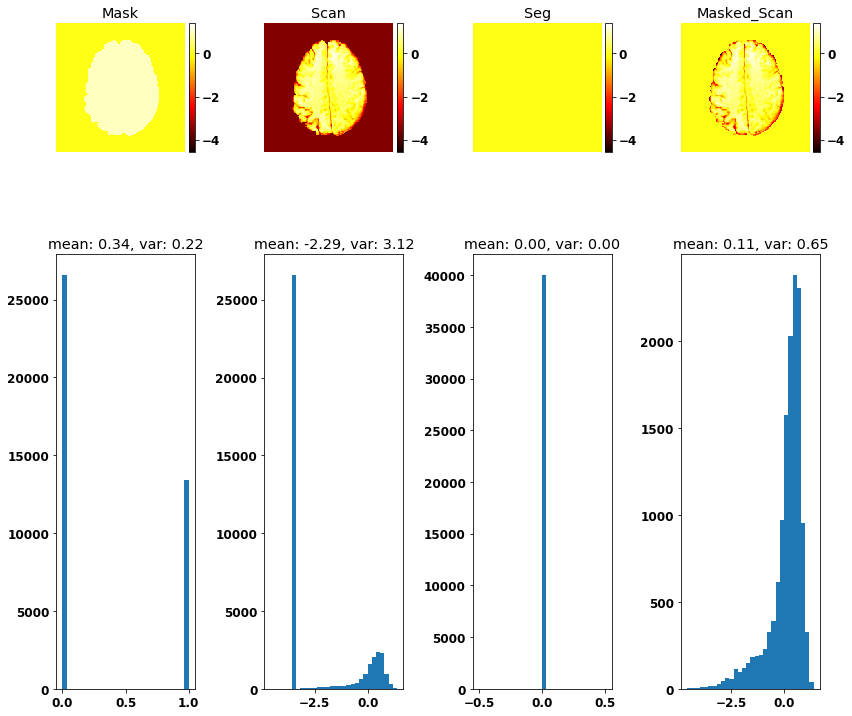

Mask           : min/max: 0.00/1.00, mean: 0.15, variance: 0.13
Scan           : min/max: -4.18/2.65, mean: -2.97, variance: 1.82
Seg            : min/max: 0.00/0.00, mean: 0.00, variance: 0.00
Masked_Scan    : min/max: -4.18/2.65, mean: 0.08, variance: 1.40


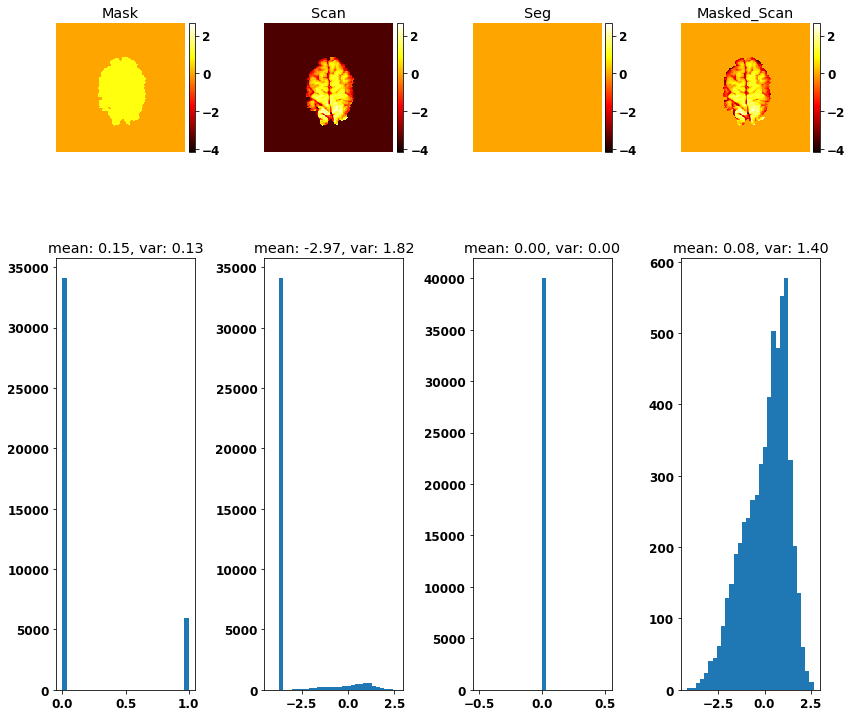

In [9]:
from uncertify.visualization.datasets import plot_samples

n_samples = 30
plot_samples(h5py.File(brats_val_path, 'r'), n_samples=n_samples, dataset_length=150, cmap='hot')
#plot_samples(h5py.File(brats_t1_path, 'r'), n_samples=n_samples, dataset_length=310, cmap='Greys')
#plot_samples(h5py.File(camcan_val_path, 'r'), n_samples=n_samples, cmap='Greys')

# Explore Dataset using Dataset and Dataloader in PyTorch

In [7]:
import torch
from torch.utils.data import DataLoader
import torchvision

from uncertify.data.datasets import Brats2017HDF5Dataset, CamCanHDF5Dataset
from uncertify.data.dataloaders import dataloader_factory, DatasetType
from uncertify.visualization.datasets import plot_brats_batches, plot_camcan_batches
from uncertify.visualization.datasets import plot_fraction_of_abnormal_pixels

## Using the dataset factory

2020-10-12 20:06:10,914 : uncertify.visualization.datasets : INFO       Plotting BraTS2017 Dataset [scan & segmentation]
2020-10-12 20:06:10,987 : matplotlib.font_manager : WARNING    findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


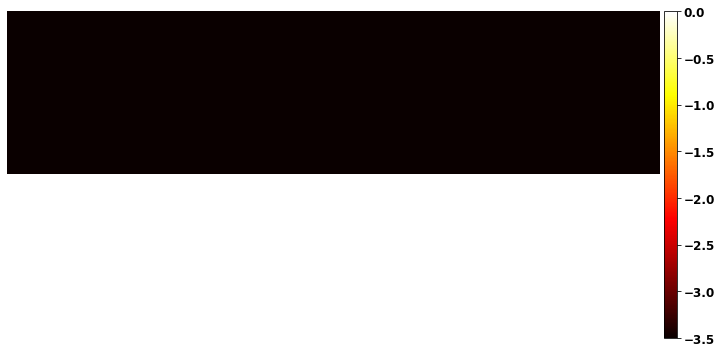

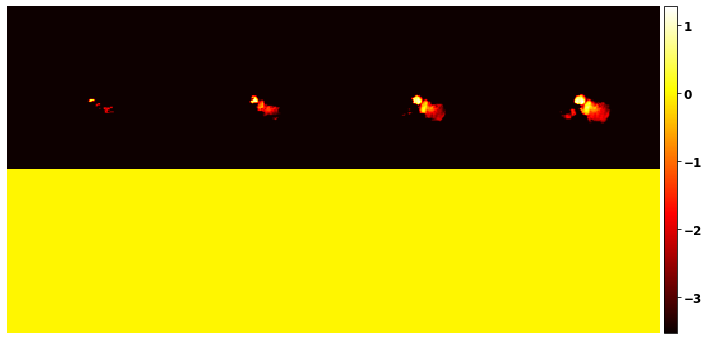

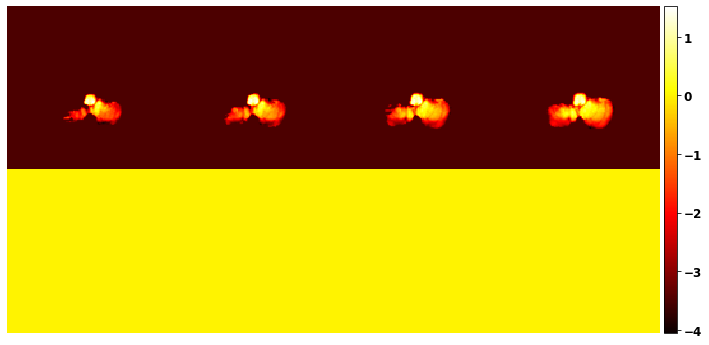

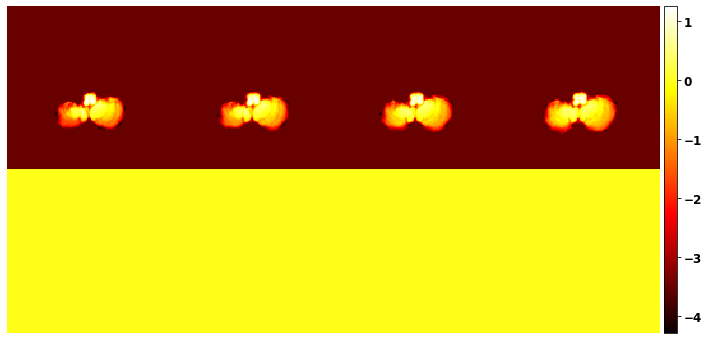

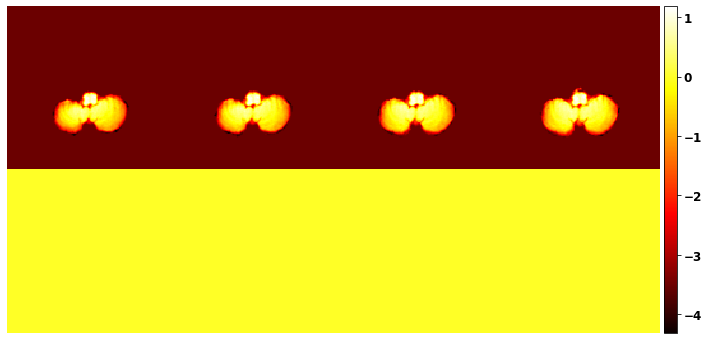

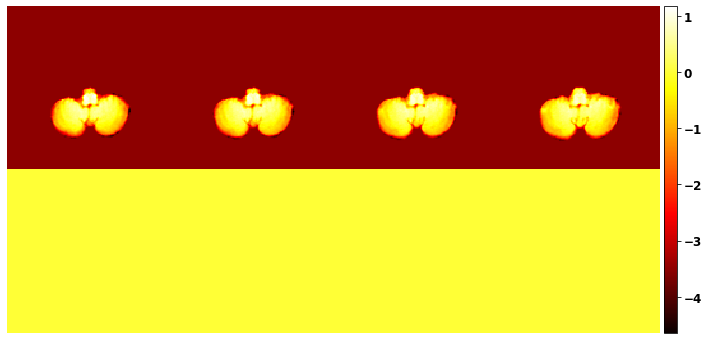

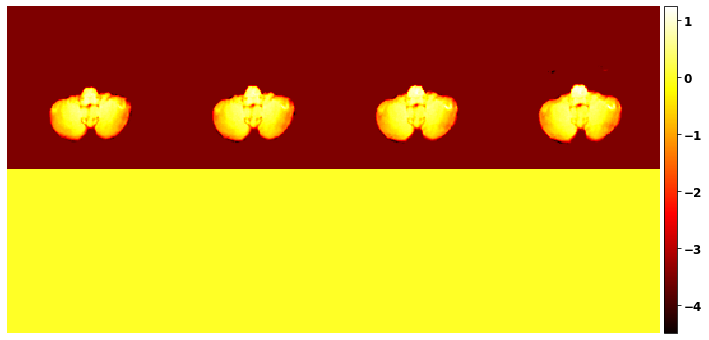

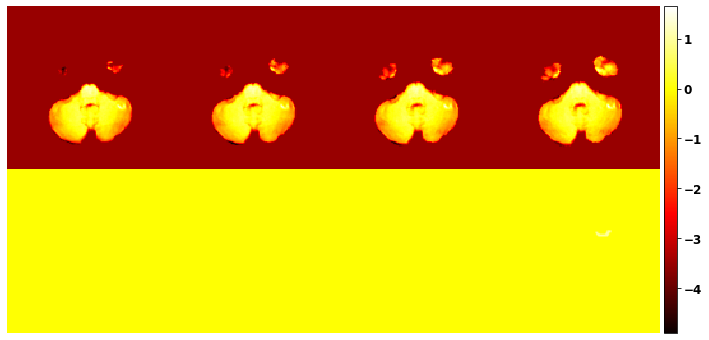

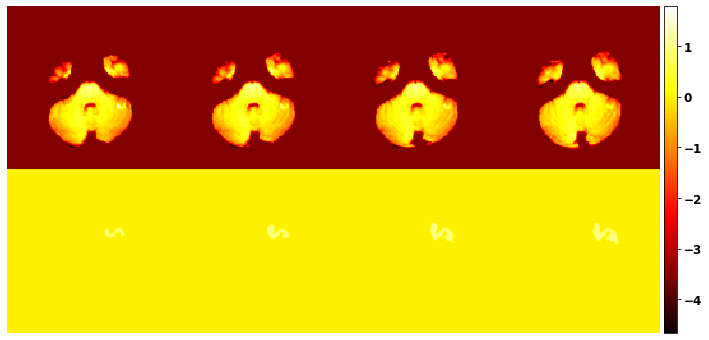

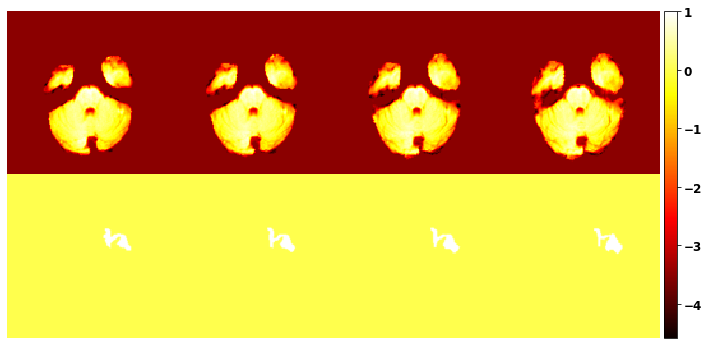

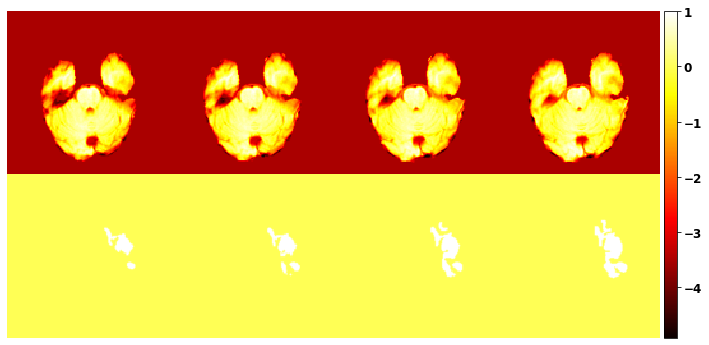

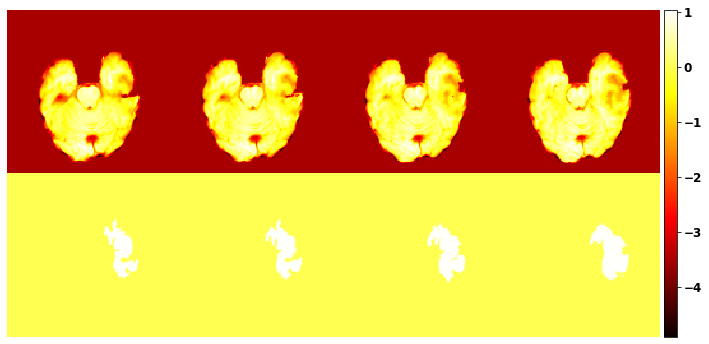

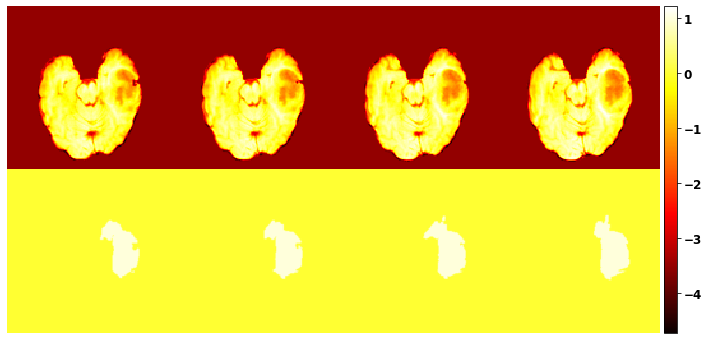

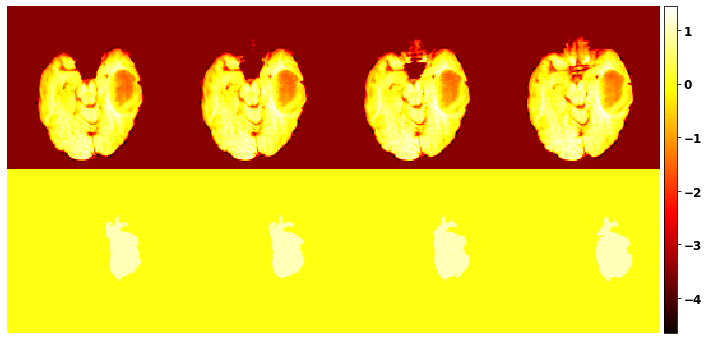

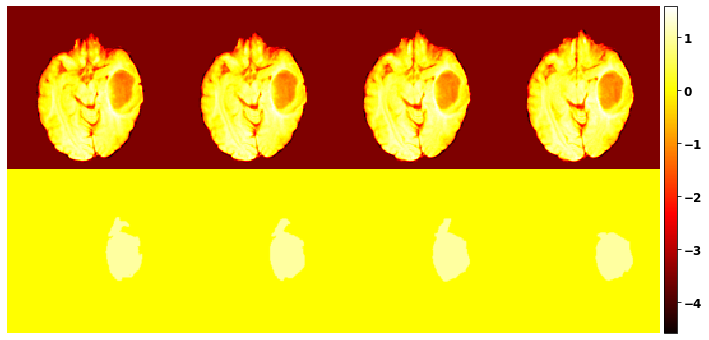

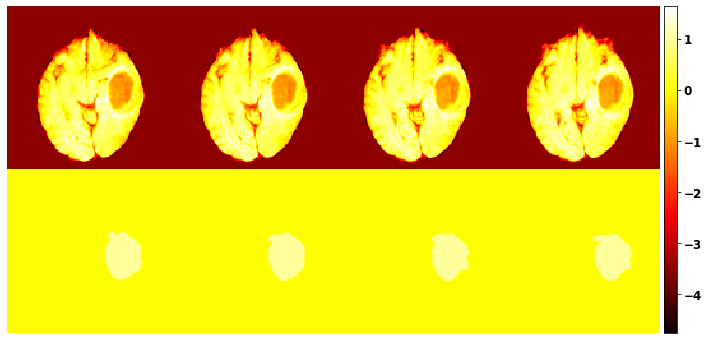

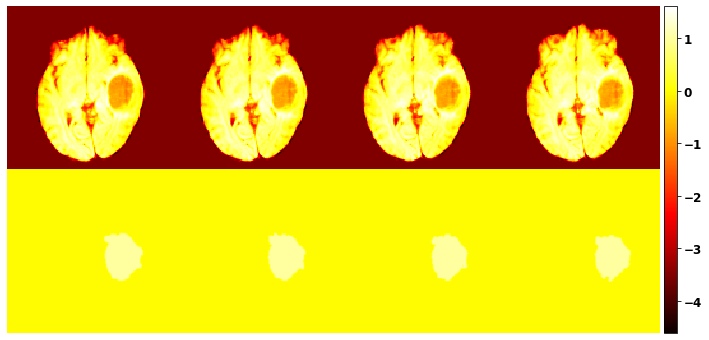

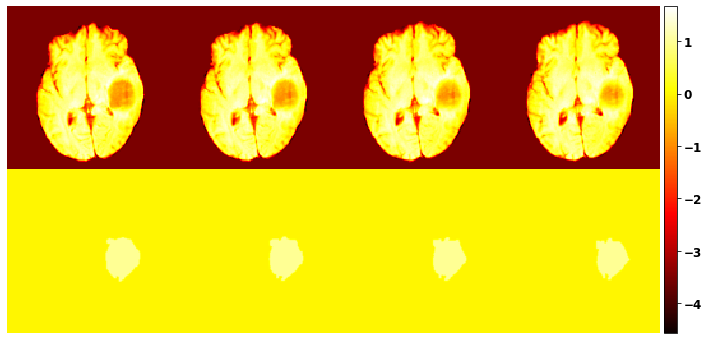

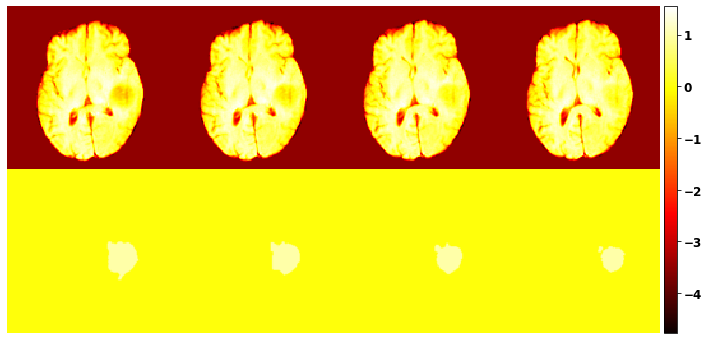

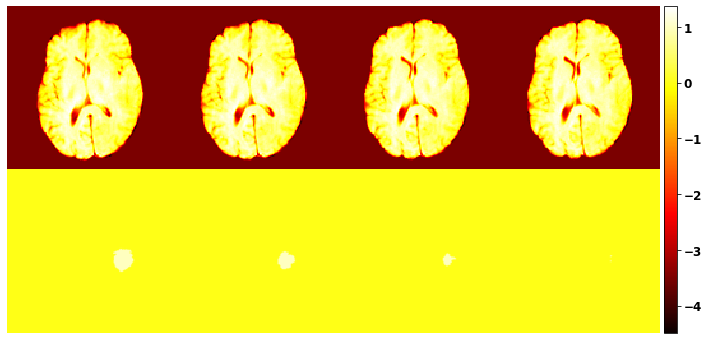

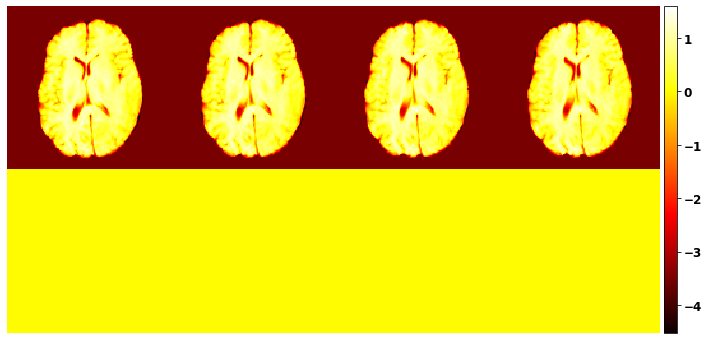

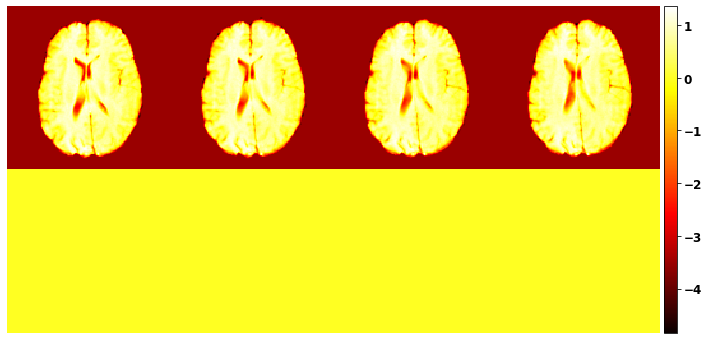

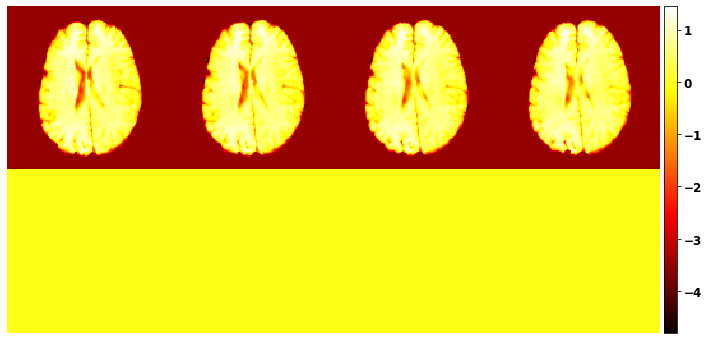

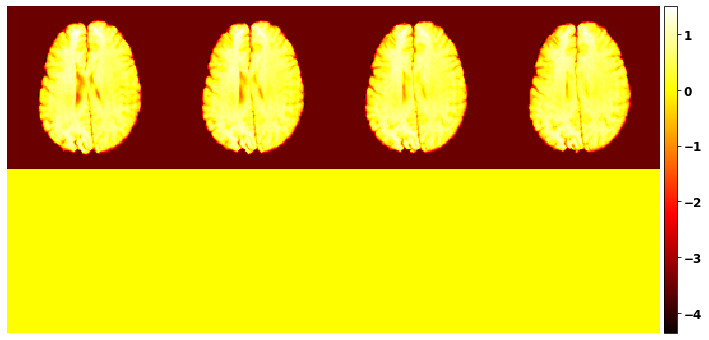

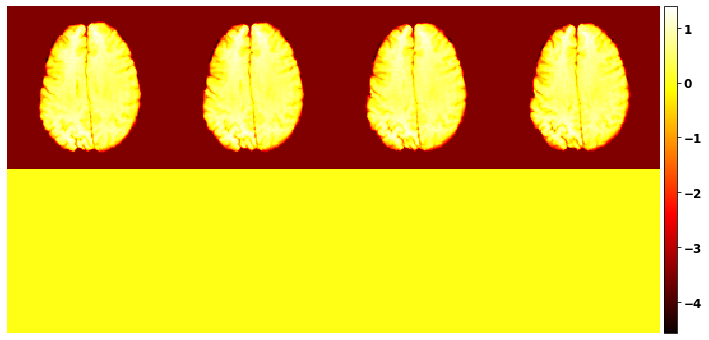

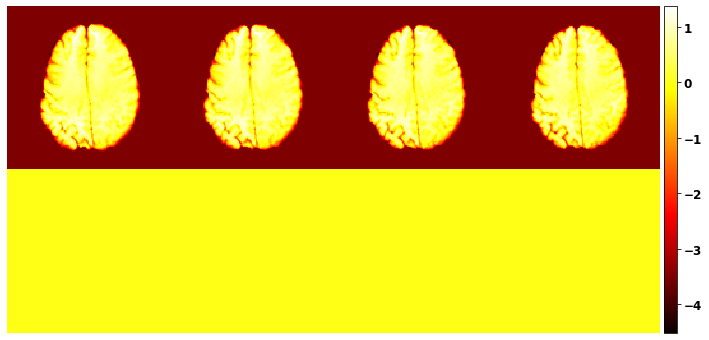

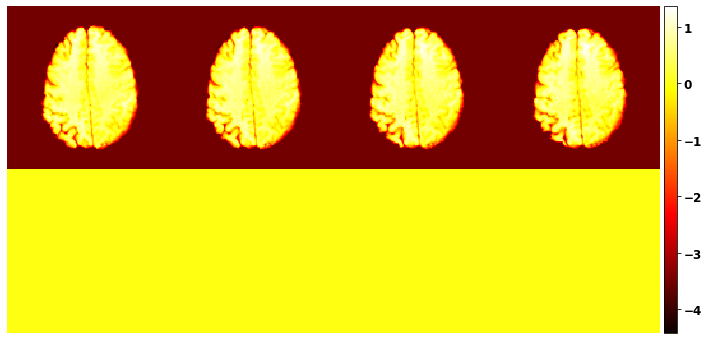

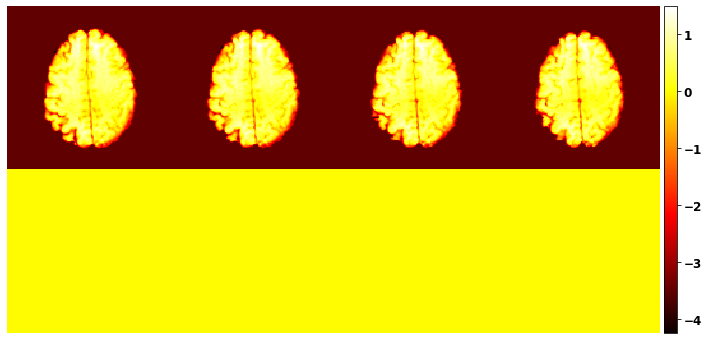

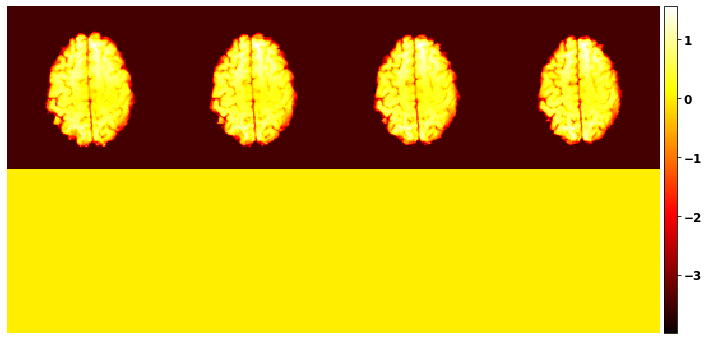

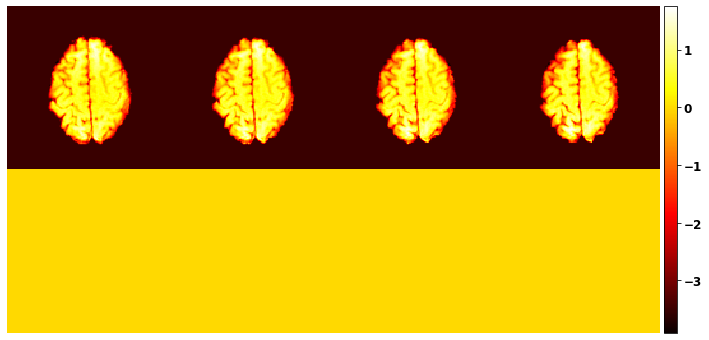

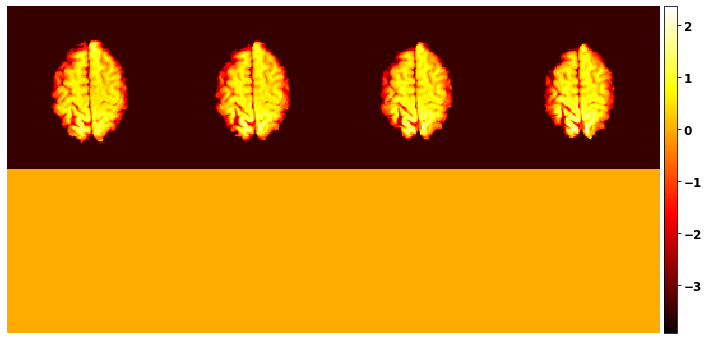

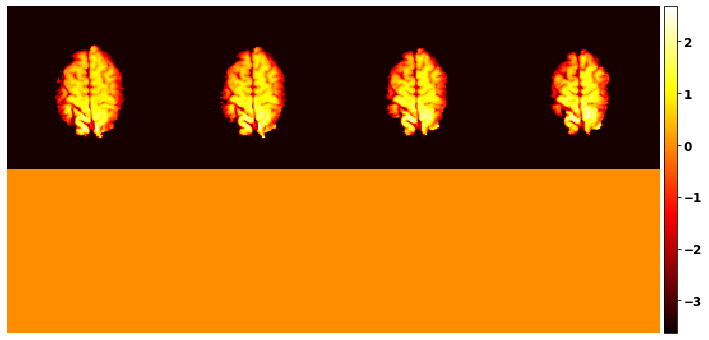

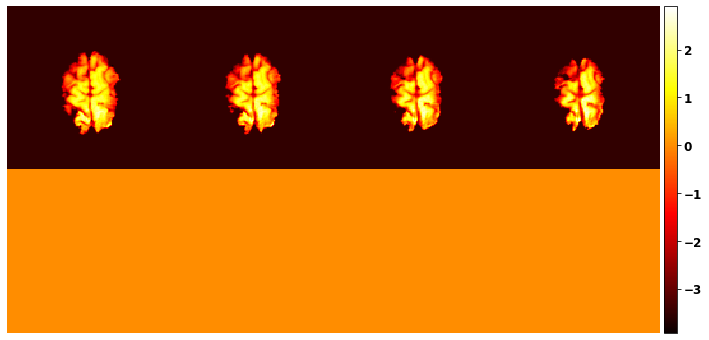

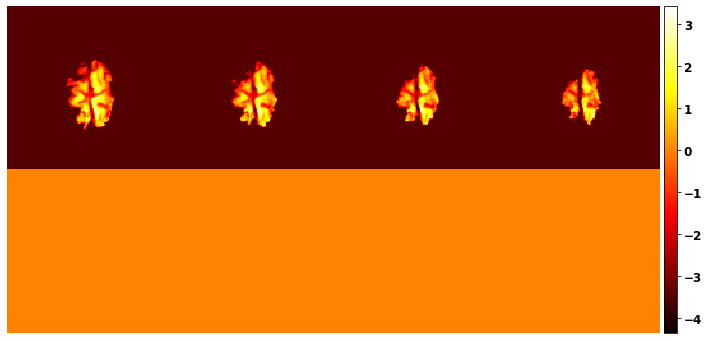

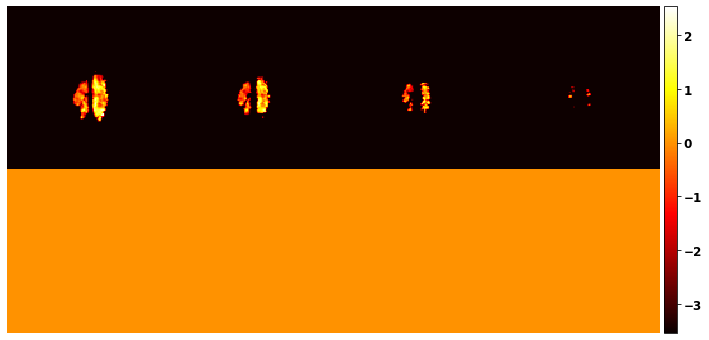

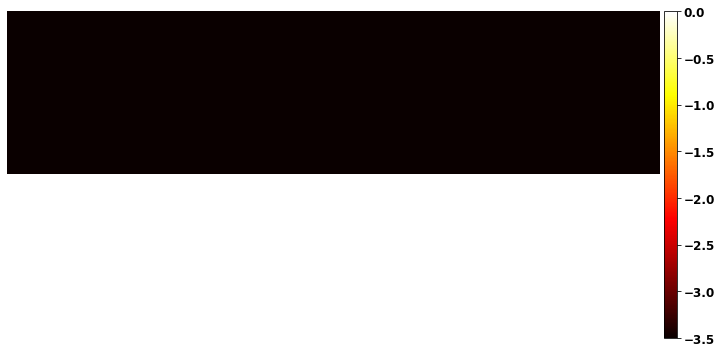

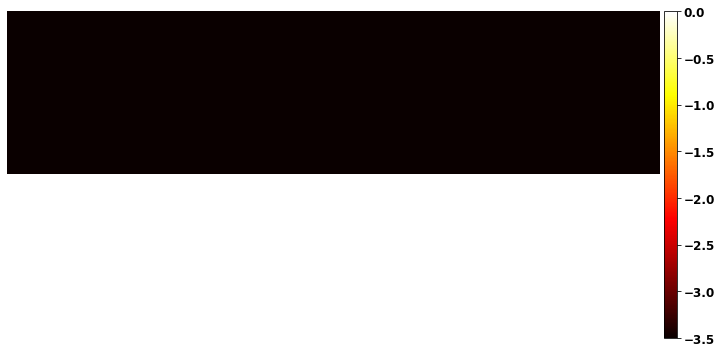

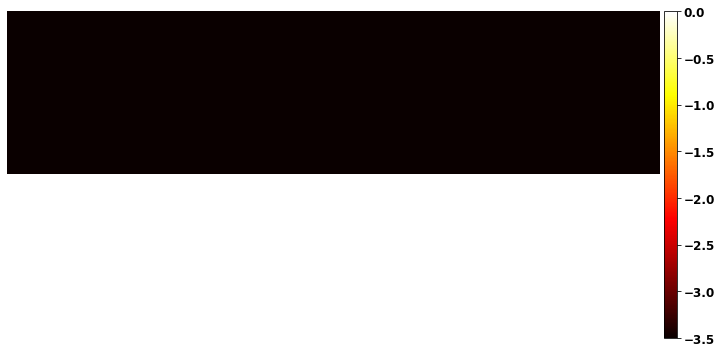

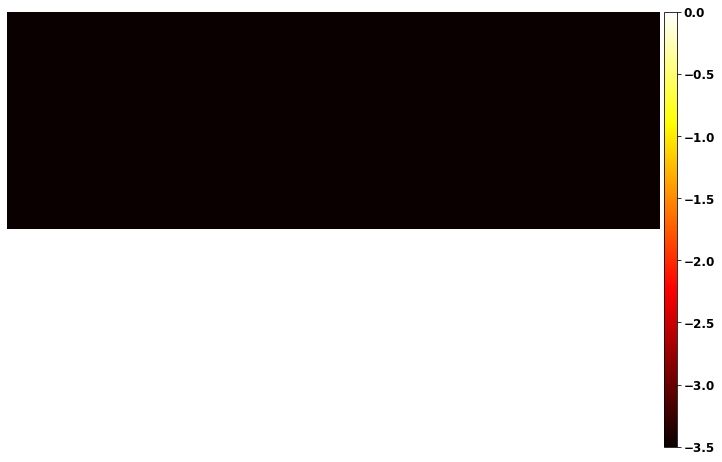

In [8]:
batch_size = 4
brats_val_path = Path('/scratch/maheer/datasets/processed/')
brats_val_path = BRATS_DATA_DIR / 'brats_test_std.hdf5'
_, brats_val_dataloader = dataloader_factory(DatasetType.BRATS17, batch_size=batch_size, path=brats_val_path, shuffle_val=False)
#_, brats_val_dataloader = dataloader_factory(DatasetType.BRATS17, batch_size=batch_size, path=DATA_DIR_PATH / 'brats/brats_all_val.hdf5', shuffle_val=True)
#_, brats_t1_dataloader = dataloader_factory(DatasetType.BRATS17, batch_size=batch_size, path=DATA_DIR_PATH / 'brats/brats_t1_no_hm_unbiased.hdf5', shuffle_val=True)
#camcan_train_dataloader, camcan_val_dataloader = dataloader_factory(DatasetType.CAMCAN, batch_size=batch_size, shuffle_val=True)
plot_n_batches = 100
plot_brats_batches(brats_val_dataloader, plot_n_batches, cmap='hot', figsize=(12, 12))
#plot_brats_batches(brats_t1_dataloader, plot_n_batches, cmap='Greys_r', vmax=4, vmin=-3.5, figsize=(12, 12))
#plot_camcan_batches(camcan_train_dataloader, plot_n_batches)
#plot_camcan_batches(camcan_val_dataloader, plot_n_batches)

# Analyze normal / abnormal pixel distribution

In [ ]:
from uncertify.evaluation.datasets import get_samples_without_lesions
from uncertify.visualization.datasets import plot_fraction_of_abnormal_pixels
from uncertify.visualization.datasets import plot_abnormal_pixel_distribution
from uncertify.visualization.datasets import boxplot_abnormal_pixel_fraction

In [ ]:
fig, _ = plot_abnormal_pixel_distribution(brats_val_dataloader, figsize=(12, 5), 
                                          hist_kwargs=dict(bins=30, density=True))
fig.savefig(DATA_DIR_PATH / 'plots' / 'normal_abnormal_n_pixel_distribution.png')

In [ ]:
fig, _ = plot_fraction_of_abnormal_pixels(brats_val_dataloader, figsize=(12, 5), 
                                          hist_kwargs=dict(bins=80, density=True))
fig.savefig(DATA_DIR_PATH / 'plots' / 'abnormal_pixel_fraction.png')

In [ ]:
fig, ax = boxplot_abnormal_pixel_fraction(data_loader=brats_val_dataloader, figsize=(2.5, 5))
fig.savefig(DATA_DIR_PATH / 'plots' / 'boxplot_abnormal_pixel_fraction.png')

In [ ]:
n_samples_without_lesions, n_higher_ratio_threshold, n_samples_total = get_samples_without_lesions(brats_val_dataloader, pixel_ratio_threshold=0.01)
print(f'{n_samples_without_lesions} / {n_samples_total} samples have lesional pixels. {n_higher_ratio_threshold} / {n_samples_total} to have more than 0.01% of lesional pixels within the brain mask.')